In [1]:
import environment as env
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Deep Q Learning - First Attempt
This is my first attempt at setting up a DQN for a model using the game Mille Bornes. See the wiki site for more info on my first attempt. I feel I was successful at learning the basics but was unsuccessful at developing the DQN.

In [2]:
# General variables
card_matrix = env.card_matrix_build()
action_matrix = env.action_matrix_build(card_matrix)

discount_factor = 0.9  # Discount factor of future rewards
optimizer = keras.optimizers.Adam(learning_rate=.001)
loss_fn = keras.losses.mean_squared_error

In [3]:
# Model: Neural Network
model_input_shape = [47]
model_n_outputs = 97

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=model_input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(model_n_outputs)
])

In [4]:
# Policy

# Balance exploration and eploitation using epsilon greedy process
def policy_dqn(state, actions, epsilon):
    """
    state (ndarray) - the game state
    actions ([int]) - valid actions
    epsilon (dec) - a value to control how much the machine explores new state/actions (random) vs. using model optimal values
    """
    if np.random.rand() < epsilon:
        # Select an action at random
        return random.choice(actions)
    
    else:
        # Use model suggested action
        Q_values = model.predict(state[np.newaxis])
        
        # Set non-legal actions to negative infinity
        for i in range(len(Q_values[0])):
            if i not in actions:
                Q_values[0][i] = -np.inf
        
        return np.argmax(Q_values[0])

# Programmatic policy - illustrate game play using pure programming logic to improve the policy
def policy_program(actions):
    """
    Programmatic policy - illustrate game play using pure programming logic (no machine learning) with simple conditions
    
    Policy will select in cascading order from the below:
        Play highest Distance card
        Play random Remedy card
        Play random non-discard option
        Discard a random card
    
    In addition, the policy will:
        Always choose to play a Coup Fourre when presented with the opportunity
        Never choose Extension play
    
    Arguments:
        actions ([int]) - actions the player can select from
    
        hand (list) - current player's hand, a list of Card objects: [Card]
    
    Return:
        int - the action to take
    """
    
    # Coup Fourre Option
    if 80 in actions or 85 in actions or 90 in actions:
        # Coup Fourre option - always play the coup fourre option (there will be only two options)
        return min(actions)
    
    # Extension Option
    if actions[0] > 90:
        # Extension option - always select "No"
        return max(actions)
    
    # Distance cards
    options = set(actions).intersection(list(range(19,24)) + list(range(38,43)) + list(range(57,62)))
    if len(options) > 0:
        return max(options)
    
    # Remedy cards
    options = set(actions).intersection(list(range(24,29)) + list(range(43,48)) + list(range(62,67)))
    if len(options) > 0:
        return random.choice(list(options))
    
    # Non-discard option
    options = set(actions).intersection(list(range(19,76)))
    if len(options) > 0:
        return random.choice(list(options))
    
    # Discard random card
    return random.choice(actions)

In [5]:
# Create collection of experiences by player relevant for the evaluating the actions they were able to take during the game
#   Only includes experiences where the player made an action, excludes:
#      Start-of-game - first round, a player may play a Safety and get 100 points, other players did not take action so there is no way to "train" a better acction
#      Extension - team may receive bonus 200-points without taking any action, no way to "train" this behavior
def create_player_experience(game):
    """
    Player experience collection
    
    game (environment.Game) - the instance of the Game class that was played
    
    Return - list with the following shape (n players, 4):
        [
            [
                states (np.array) shape (n experiences, 47)
                actions (np.array) shape (n experiences,)
                rewards (np.array) shape (n experiences,)
                next_states (np.array) shape (n experiences - 1, 47) - Note: no entry for last experiences, end-of-game ("done")
            ], ...
        ]
    """
    # Use in loop iteration
    player_count = len(game.players)
    player_range = range(player_count)
    
    # Basic list structure
    player_experience = [ [ [], [], [], [] ] for i in player_range]
    
    # Used to calculate a player's reward for a full round of play (reward = player action points + team player action points - opponent players action points)
    reward_round = [0] * player_count
    
    # Loop in reverse to calculate rewards from a given action
    for act in reversed(game.action_history):
        for i in player_range:
            player = game.players[i]
            if act[0] == player and act[2] > -1:
                # Record this action and reset reward round for this player
                reward_round[i] += act[3]
                player_experience[i][0].append(act[1])  # State
                player_experience[i][1].append(act[2])  # Action
                player_experience[i][2].append(reward_round[i])  # Reward
                if len(player_experience[i][0]) > 1:
                    player_experience[i][3].append(player_experience[i][0][-2])  # Next State
            
                reward_round[i] = 0
            else:
                # Adjust reward
                reward_round[i] += act[3] * (1 if act[0].team == player.team else -1)
    
    # Reverse list orders to be in game play order and convert lists to numpy arrays
    for i in player_range:
        for j in range(4):
            player_experience[i][j].reverse()
            player_experience[i][j] = np.array(player_experience[i][j])
    
    return player_experience

In [6]:
# Play a game

def play_game(players_name, players_policy, epsilon):
    """
    players_name ([str]) - name of players
    players_policy ([str]) - policy to apply to each player
    epsilon (dec) - value to use when evaluating the explore/exploit policy
    
    Return Game
    """
    game = env.Game(players_name)
    
    # Loop game play
    while game.play_status < 4:
        # Policy
        policy_type = players_policy[players_name.index(game.player_current.name)]
        if policy_type == "dqn":
            action = policy_dqn(np.array(game.state()), game.player_actions, epsilon)
        else:
            action = policy_program(game.player_actions)
        
        # Play the step
        game.play_action(action)
    
    return game

In [7]:
# Train model after game completed
def train_model(player_experience):
    """
    Train the model
    
    player_experience - the arrays associated with the desired player
    """
    
    # Data for person to process
    states, actions, rewards, next_states = player_experience

    # ----- Q values for next states
    Q_values_next_state = model.predict(next_states)

    # Filter next state Q values to only valid actions
    valid_actions = [env.actions_space(next_state, card_matrix, action_matrix) for next_state in next_states]
    Q_values_next_state_valid = [
        [Q_values_next_state[i][j] for j in valid_actions[i]]
        for i in range(len(Q_values_next_state))
    ]

    # Get the max Q value for each next state
    Q_values_next_state_max = [max(q) for q in Q_values_next_state_valid]

    # Add 0 to end to represent max Q value for the end of game ("done" state)
    Q_values_next_state_max.append(0.0)

    # Convert to numpy array
    Q_values_next_state_max = np.array(Q_values_next_state_max)

    # Target Q values: Bellman function: rewards + discounted future rewards (max Q value from the next state as model is assumed to act optimally)
    Q_values_target = (rewards + discount_factor * Q_values_next_state_max)

    # ----- Q values for states, compute loss and train model

    # Create mask to retain only the actions that were taken for each action
    mask = tf.one_hot(actions, model_n_outputs)

    # Calculate the gradient descent (target values the model would have taken under optimal scenario vs. actual actions taken)
    with tf.GradientTape() as tape:
        # Retrieve Q values for all possible actions in each state
        Q_values_state_all = model(states)

        # Retain only Q values for actions taken (state-action pair - uses "mask")
        Q_values_state = tf.reduce_sum(Q_values_state_all * mask, axis=1, keepdims=True)

        # Compute loss
        loss = tf.reduce_mean(loss_fn(Q_values_target, Q_values_state))
    gradients = tape.gradient(loss, model.trainable_variables)

    # Optimize the model
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [8]:
# Play a tournament (multiple games)
def play_tournament(players_name, players_policy, n_games):
    """
    Play's multiple games for the specific players based on their policies
    
    players_name ([str]) - player's names
    players_policy ([str]) - policy to decide action for each player
    n_games (int) - number of games to play
    """
    
    # General variables
    players_range = range(len(players_name))
    
    # Statistics to track
    tournament_winner_points = []
    tournament_winner_team = []
    tournament_player_rewards = [[] for i in players_range]
    
    # After 90% of games have been run, epsilon should be 0.01 (highest liklihood the policy will select the DQN option)
    epsilon_max = int(n_games * .9)
    
    # Identify player to train model
    dqn_player_index = players_policy.index('dqn')
    
    for i in range(n_games):
        # Determine epsilon for DQN
        epsilon = max(1 - i / epsilon_max, 0.01)
        
        # Play a game and then get player's experiences
        game = play_game(players_name, players_policy, epsilon)
        player_experience = create_player_experience(game)
        
        # Track statistics
        team_points = game.final_team_points()
        max_points = max(team_points)
        tournament_winner_points.append(max_points)
        tournament_winner_team.append(team_points.index(max_points) if team_points.count(max_points) == 1 else -1)
        
        for i in players_range:
            tournament_player_rewards[i].append(np.sum(player_experience[i][2]))

        # Train the model (for Larry)
        train_model(player_experience[dqn_player_index])
        
    # Return statistics
    return (tournament_winner_points, tournament_winner_team, tournament_player_rewards)

In [ ]:
# Testing
players_name = ['Bob', 'Larry', 'Jr']
players_policy = ['program', 'dqn', 'program']
n_games = 500

winner_points, winner_team, player_rewards = play_tournament(players_name, players_policy, n_games)

In [24]:
# Print stats
print("Winner Points stats")
print(f"  Mean: {np.mean(winner_points)}")
print(f"  St Dev: {np.std(winner_points)}")
print(f"  Min: {np.min(winner_points)}")
print(f"  Max: {np.max(winner_points)}")
print()

print("Winning Team (counts)")
team_count = len(players_name) if len(players_name) < 4 else len(players_name) // 2
for i in range(team_count):
    print(f"  Team {i + 1}: {len([t for t in winner_team if t == i])}")
print()
    
print("Player Rewards")
for i in range(len(players_name)):
    print(f"  {players_name[i]}")
    print(f"    Mean: {np.mean(player_rewards[i])}")
    print(f"    St Dev: {np.std(player_rewards[i])}")
    print(f"    Min: {np.min(player_rewards[i])}")
    print(f"    Max: {np.max(player_rewards[i])}")

Winner Points stats
  Mean: 1256.8
  St Dev: 399.83279005104123
  Min: 300
  Max: 2900

Winning Team (counts)
  Team 1: 264
  Team 2: 16
  Team 3: 215

Player Rewards
  Bob
    Mean: -182.15
    St Dev: 816.3976528016234
    Min: -2650
    Max: 1750
  Larry
    Mean: -1549.75
    St Dev: 645.1695029215191
    Min: -3450
    Max: 1125
  Jr
    Mean: -303.4
    St Dev: 814.1719351586617
    Min: -2450
    Max: 2100


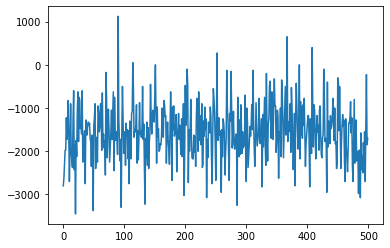

In [25]:
fig, ax = plt.subplots()
ax.plot(range(len(player_rewards[1])), player_rewards[1])